# Sistema de Recomendação com a biblioteca surprise
Aqui nós vamos implementar um simples **Sistema de Recomendação** com a biblioteca **[Surprise](http://surpriselib.com/)**

## 01 - Preparando o Ambiente & Conjunto de dados

### 01.1 - Baixando a biblioteca "surprise"
A primeira coisa que nós vamos fazer é baixar a biblioteca **[Surprise](http://surpriselib.com/)** que é uma biblioteca especifica para **Sistemas de Recomendação**.

In [2]:
#conda install -c conda-forge scikit-surprise
#!pip install scikit-surprise

### 01.2 - Importando as bibliotecas necessárias
Agora vamos importar as bibliotecas necessárias para criar nosso **Sistema de Recomendação**.

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import surprise

from datetime import datetime

### 01.3 - Pegando o conjunto de dados
Agora nós vamos pegar o conjunto de dados **[FilmTrust](https://guoguibing.github.io/librec/datasets.html)** que basicamente vai ter:

 - ID dos usuários;
 - ID do filme;
 - Nota (rating) que foi dado ao filme.

In [4]:
df = pd.read_csv(
  "datasets/ratings.txt", # Get dataset.
  sep=" ", # Separate data by space.
  names=["user_id", "movie_id", "rating"] # Set columns names.
)

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35497 entries, 0 to 35496
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   35497 non-null  int64  
 1   movie_id  35497 non-null  int64  
 2   rating    35497 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 832.1 KB


,user_id,movie_id,rating
0,1,1,2.0
1,1,2,4.0
2,1,3,3.5
3,1,4,3.0
4,1,5,4.0


**NOTE:**  
Vejam que nós temos **35.497** amostras e 3 colunas (features).

---

## 02 - Análise Exploratória dos dados (EDA)
Agora nós vamos fazer uma breve **Análise Exploratória dos dados (EDA)** no nosso conjunto de dados a fim de tirar insights dos mesmos.

### 02.1 - Contabilizando o número total de filmes (movies), usuários (users) e amostras (samples)

In [10]:
movies  = len(df["movie_id"].unique())
users   = len(df["user_id"].unique())
samples = df.shape[0]

print("Total movies:", movies)
print("Total users:", users)
print("Total samples:", samples)

Total movies: 2071
Total users: 1508
Total samples: 35497


**NOTE:**  
Como podem ver nós temos apenas **35.497** amostras, mas as combinações entre **filmes (movies)** e **usuários (users)** é bem maior que isso:

```python
2.071 x 1.508 = 3.123.068
```

Ou seja, temos muitos dados faltantes (missing) e isso pode ocorrer porque alguns usuários apenas não viram determinados filmes. Por isso, vai ser interessante tentar ***prever*** esses valores.

Por exemplo, vamos olhar as 20 primeiras amostras:

In [16]:
df.head(20)

,user_id,movie_id,rating
0,1,1,2.0
1,1,2,4.0
2,1,3,3.5
3,1,4,3.0
4,1,5,4.0
5,1,6,3.5
6,1,7,3.5
7,1,8,3.0
8,1,9,2.5
9,1,10,4.0


**NOTE:**  
Com apenas 20 amostras já da para tirar algumas concluções:
 - O usuário 1 viu apenas 12 filmes:
   - Ou seja, teremos que fazer inúmeras previsões de notas (rating) de filmes para esse usuário.
 - O usuário 2 viu apenas 2 filme:
   - Pior ainda, podemos ter até um problema de underfitting para prever notas (rating) para esse usuário visto que o nosso Algoritmo não vai generalizar o suficiente.

### 02.2 - Contabilizando o número de  notas (rating)

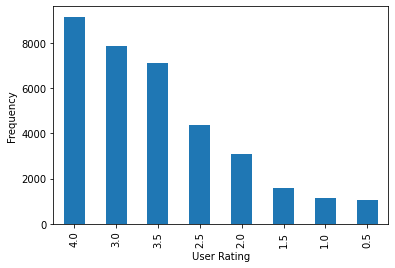

In [17]:
df['rating'].value_counts().plot(kind="bar")
plt.xlabel("User Rating")
plt.ylabel("Frequency")
plt.show()

**NOTE:**  
Olhando para o gráfico acima nós temos que:
 - A nota (rating) mínima foi 0.5;
 - A nota (rating) máxima foi 4.0;
 - A nota (rating) mais frequente foi 4.0.

Vamos ver esse mesmo resultado, porém, utilizando outra abordagem, apenas para fins de ensino.

In [22]:
max_rating = df["rating"].max()
min_rating = df["rating"].min()
print("Max rating: {0} \nMin rating: {1}".format(max_rating, min_rating))

Max rating: 4.0 
Min rating: 0.5


---

## 03 - Preparando & Treinando um modelo

### 03.1 - Redefinindo o range do ratings
Por padrão a classe **surprise.Reader** tem o range (escala) de rating de **rating_scale=(1, 5)**, então, vamos redefinir esse parâmetro para se ajustar a nossa necessidade, ou seja, de **0.5** até **4.0**.

In [29]:
reader = surprise.Reader(rating_scale = (0.5, 4.0)) # Your can load a built-in dataset here.

In [30]:
# Load df to surprise library + Pass rating_scale
df_surprise = surprise.Dataset.load_from_df(df, reader)

### 03.2 - Escolhendo o Algoritmo e treinando o modelo (ou seja, criando as features)

In [32]:
df_filled = df_surprise.build_full_trainset()
algorithm = surprise.SVDpp(n_factors=20) # SVD++ instance.
algorithm.fit(df_filled)

**NOTE:**  
A parte do código acima nada mais do que utilizar o algoritmo **SVD++** para criar as *features* para o nosso conjunto de dados. Por padrão, o algoritmo criar 20 features (n_factors=20). Outra observação é que ele está utilizando o método **Matrix Factorization**.

### 03.3 - Criando um DataFrame com os dados faltantes/missing
Como nós sabemos, nós temos:

```python
Total movies: 2071
Total users: 1508
Total samples: 35497
```

O que nos resultaria em:

```python
2.071 x 1.508 = 3.123.068
```

Ou seja, ainda faltam milhões de combinações de usuários e notas (rating) para filmes. Como nós criamos as *features* para esse conjunto de dados agora vamos ***prever*** as combinações faltantes.

In [37]:
start_time = datetime.now()

df_missing = df_filled.build_anti_testset()
missing_values_predicted = algorithm.test(df_missing)

end_time = datetime.now()
print('Runtime to predict missing values:: {}'.format(end_time - start_time))

Runtime to predict missing values:: 0:02:45.499856


Agora nós já temos os valores que foram *previstos* na variável **missing_values_predicted**. Por exemplo, vamos dar uma olhada na primeira previsão:

In [38]:
missing_values_predicted[0]

Prediction(uid=1, iid=13, r_ui=3.0028030537791928, est=3.44228412861595, details={'was_impossible': False})

Olhando para a saída acima nós temos que:
 - **uid:**
   - ID do usuário.
 - **iid:**
   - ID do filme.
 - **est:**
   - O valora/nota (rating) previsto.

Mas qual o tamanho máximo de previsões que foram feitas?

In [39]:
len(missing_values_predicted)

3087574

Você pode conferir isso manualmente para ver se realmente nós temos as combinações faltantes:

```python
Total movies: 2071 * Total users: 1508
2.071 x 1.508 = 3.123.068
````

Agora vamos subtrair desse valor o número de amostras que nós já temos **Total samples: 35497**:

```python
3.123.068 - 35497 = 3.087.574
```

### 03.4 - Pegando as TOP recomendações por usuário
Agora nós vamos criar uma função que retorne o top-N recomendações para cada usuário. Essa função retorna um **dicionário**, onde, as chaves são os usuários e os valores são listas de tuplas.

In [40]:
from collections import defaultdict

def get_top_recommendations(predicts, n=5):
  top_n = defaultdict(list) # Create a dictionary where lists are empty.
  for user, movie, _, predict, _ in predicts:
    top_n[user].append((movie, predict)) # Add key-value
  for user, user_predicts in top_n.items():
    user_predicts.sort(key=lambda x: x[1], reverse=True) # Order predicts rating from high to less.
    top_n[user] = user_predicts[:n] # Save only the first values.
  return top_n

Vamos começar pegando as top 5 recomendações (que é o valor default da função get_top_recommendations) para cada usuário:

In [43]:
top_five = get_top_recommendations(missing_values_predicted)

In [44]:
top_five

defaultdict(list,
            {1: [(286, 4.0),
              (805, 3.9848799984366123),
              (335, 3.897681343287051),
              (476, 3.8589558778500668),
              (689, 3.847493656367476)],
             2: [(286, 3.6581621170563956),
              (805, 3.555846569188274),
              (335, 3.4861171789097187),
              (318, 3.425881836392946),
              (400, 3.4125050837845268)],
             3: [(211, 4.0),
              (365, 4.0),
              (479, 3.9805708845486647),
              (13, 3.9752911400811843),
              (542, 3.952312583107548)],
             4: [(286, 3.3721242145550545),
              (335, 3.296696117817915),
              (318, 3.2698835218616455),
              (805, 3.259559884214817),
              (307, 3.194626069571189)],
             5: [(286, 3.770120345077694),
              (805, 3.733597397831983),
              (335, 3.64184894045676),
              (675, 3.6315783542641475),
              (689, 3.625975210387105

Olhando para a saída acima nós temos:
 - Um dicionário onde:
   - A chave é o ID do usuário
   - E os valores são uma lista de duplas, onde:
     - O primeiro elemento da tupla representa o ID do filme;
     - O segundo elemento da tupla representa a nota (rating) do filme.
     - Isso tudo em ordem decrescente, ou seja, da maior nota (rating) para a menor.

**NOTE:**  
Agora você pode pegar essa saída e trabalhar com ela da maneira que você desejar, por exemplo, passar para uma API e etc. Só por questão didática vamos pegar essa saída (dicionário) e criar uma mecanismo, onde, nós vamos ter o ID do usuário e uma lista com os top 5 filmes por ID e não por nota (rating).

In [45]:
for user, user_predicts in top_five.items():
  print(user, [movie for (movie, _) in user_predicts])

1 [286, 805, 335, 476, 689]
2 [286, 805, 335, 318, 400]
3 [211, 365, 479, 13, 542]
4 [286, 335, 318, 805, 307]
5 [286, 805, 335, 675, 689]
6 [286, 335, 805, 675, 318]
7 [286, 335, 805, 363, 696]
8 [286, 805, 335, 675, 363]
9 [286, 805, 335, 363, 307]
10 [286, 805, 689, 705, 1091]
11 [286, 335, 805, 675, 563]
12 [286, 335, 805, 363, 318]
13 [286, 299, 318, 335, 307]
14 [286, 805, 675, 335, 658]
15 [286, 675, 805, 363, 335]
16 [318, 286, 689, 805, 335]
17 [286, 335, 805, 299, 675]
18 [286, 805, 335, 363, 299]
19 [286, 335, 805, 318, 675]
20 [286, 805, 335, 563, 299]
21 [52, 68, 96, 126, 189]
22 [68, 96, 181, 189, 218]
23 [286, 805, 335, 299, 689]
24 [286, 318, 675, 335, 563]
25 [318, 335, 805, 689, 286]
26 [286, 335, 805, 318, 363]
27 [299, 805, 286, 335, 1091]
28 [286, 318, 805, 675, 335]
29 [805, 335, 689, 189, 658]
30 [1027, 398, 805, 286, 363]
31 [286, 335, 805, 689, 307]
32 [286, 805, 335, 307, 299]
33 [335, 286, 299, 805, 398]
34 [286, 318, 335, 675, 805]
35 [286, 805, 335, 318, 68

858 [286, 805, 335, 299, 675]
859 [286, 805, 675, 335, 299]
860 [286, 805, 335, 425, 525]
861 [68, 96, 126, 167, 181]
862 [167, 279, 286, 297, 299]
863 [286, 805, 675, 335, 657]
864 [286, 805, 335, 675, 696]
865 [286, 805, 335, 398, 363]
866 [286, 805, 335, 675, 299]
867 [805, 286, 335, 689, 297]
868 [286, 335, 805, 675, 363]
869 [318, 286, 805, 335, 197]
870 [286, 805, 335, 675, 299]
871 [675, 335, 286, 805, 318]
872 [286, 805, 335, 307, 563]
873 [286, 335, 805, 299, 318]
874 [286, 299, 318, 335, 675]
875 [318, 335, 286, 805, 675]
876 [286, 318, 335, 805, 689]
877 [286, 805, 335, 689, 675]
878 [805, 398, 335, 286, 400]
879 [805, 286, 398, 363, 525]
880 [286, 805, 335, 297, 675]
881 [805, 286, 689, 1091, 335]
882 [286, 805, 689, 218, 335]
883 [286, 299, 318, 335, 363]
884 [286, 805, 689, 335, 675]
885 [286, 805, 335, 299, 307]
886 [286, 318, 335, 675, 805]
887 [286, 299, 335, 805, 318]
888 [286, 318, 335, 675, 805]
889 [286, 805, 335, 363, 563]
890 [286, 318, 335, 805, 689]
891 [675, 3

**NOTE:**  
Uma observação aqui é que esses ID dos filmes estão ordenados de modo que os filmes que tiveram melhor nota (rating) sejam os primeiros.

> Então, não confunda o ID dos filmes com as notas (rating).

### 03.5 - Fazendo previsões para um usuário e filme específico
Ok, mas como eu posso fazer uma previsão para um usuário e filme específico? Simples, vejam o código abaixo:

In [49]:
user_30_predict = algorithm.predict(uid="30", iid="87")
user_30_predict

Prediction(uid='30', iid='87', r_ui=None, est=3.0028030537791928, details={'was_impossible': False})

**NOTE:**  
Vejam que nós temos as previsões para o usuário 30. Por exemplo, nós podemos pegar a nota (rating) que foi prevista apenas utilizando o atributo **est**:

In [50]:
rating = user_30_predict.est
print(rating)

3.0028030537791928
